In [1]:
#load requirements for working with PCs
from vedo import *
from ipyvtklink.viewer import ViewInteractiveWidget
import numpy as np
import tensorflow as tf
import time
import cv2

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 2*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

import sys
import os
current = os.getcwd()
parent_directory = os.path.dirname(current)
sys.path.append(parent_directory)
sys.path.append(parent_directory+"/point_cloud_rectification")
from ICET_spherical import ICET
from linear_corrector import LC

from utils import R_tf
from metpy.calc import lat_lon_grid_deltas
from scipy.spatial.transform import Rotation as R
from matplotlib import pyplot as plt
import copy
import trimesh


from pillow_heif import register_heif_opener
from matplotlib import pyplot as p
from colmapParsingUtils import *
from scipy.spatial.transform import Rotation as R
import cv2

from tqdm import tqdm_notebook as tqdm
from PIL import Image

tf.compat.v1.enable_eager_execution()


%load_ext autoreload
%autoreload 2
%autosave 180
# %matplotlib notebook

2024-04-02 17:51:51.125077: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-02 17:51:51.219117: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-02 17:51:51.610250: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-04-02 17:51:51.610304: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-04-02 17:51:52.350500: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-02 17:51:52.351356: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-02 17:51:52.351536: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-02 17:51:52.351663: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Autosaving every 180 seconds


In [120]:
#load raw point cloud data from Newer College Dataset

#NEWER COLLEGE
idx = 500 
fn1 = "/media/derm/06EF-127D4/Newer College Dataset/01_Short_Experiment/point_clouds/frame_" + str(idx) + ".npy"
pc1 = np.load(fn1)
pc1 = np.flip(pc1, axis = 0)#flip to maintain CCW convention

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]
## purple -> green
color = 255*np.linspace(0,1,len(pc1)) 
cname = np.array([255-color, color, 255-color]).T.tolist()
disp.append(Points(pc1, c=cname,  r = 3.5, alpha =0.5))
print(len(pc1) / 128)

#remove NaNs
# pc1[pc1[:,0]>64] = 100
# pc1[pc1[:,0]<-64] = 100
pc1 = np.nan_to_num(pc1, nan=0.0)

plt.show(disp, "Raw Point Cloud")
ViewInteractiveWidget(plt.window)

512.0


ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

# Convert Point Cloud to Depth Image

In [121]:
%matplotlib notebook

pc1_spherical = LC.c2s(LC,pc1).numpy() #[r, theta, phi] --> theta = azimuth, phi = elevation
# print(pc1_spherical)
pc1_spherical = np.nan_to_num(pc1_spherical, nan=0.0)

# #TODO: make sure the depth image stays at exactly a 360deg sweep ~~~
# #issue with points at the beginning of the scan starting with theta < 0
# less_than_zero = np.where(pc1_spherical[:,1] < 0)[0]
# less_than_zero = less_than_zero[less_than_zero[:] < len(pc1_spherical)//4]

# # print(np.linspace(0,len(pc1_spherical)-1,len(pc1_spherical)))
# good_idx = np.setdiff1d(np.linspace(0,len(pc1_spherical)-1,len(pc1_spherical), dtype = int), less_than_zero)

# print(good_idx)
# # %matplotlib notebook
# fig, ax = p.subplots()
# # ax.plot(less_than_zero)

# pc1_spherical = pc1_spherical[good_idx]
# ax.plot(pc1_spherical[:,1])
# # ax.plot(np.diff(pc1_spherical[:,1]))
# #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

depth_image = np.zeros([64, len(pc1_spherical)//64])
# depth_image = np.zeros([128, len(pc1_spherical)//128])
# print(len(pc1_spherical)/128)

#set points of radius zero (i.e. non returns) to large values
depth_image = pc1_spherical.copy()
non_return_idx = np.argwhere(depth_image == 0)
# print(non_return_idx)
depth_image[non_return_idx[:,0], non_return_idx[:,1]] = 10

<IPython.core.display.Javascript object>


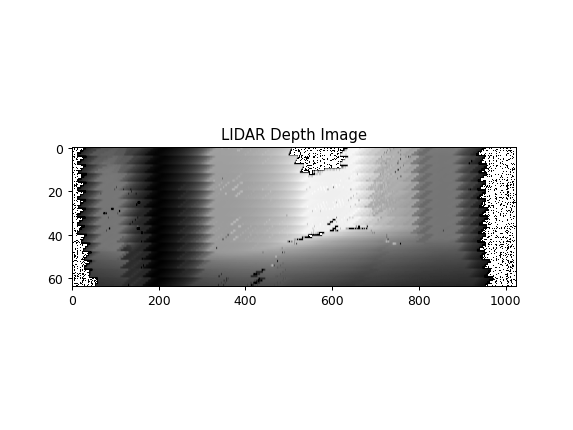

(64, 1024)


In [122]:
pc1_spherical = LC.c2s(LC,pc1).numpy() #[r, theta, phi] #test commenting out
pcs = np.reshape(pc1_spherical, [-1,64,3])
pcs = np.flip(pcs, axis = 1)


#default <pixel_shift_by_row> = [18, 12, 6, 0, ..., 18, 12, ...]



# pcs = pcs[np.argsort(pcs, axis = 1)[:,0,0]]
# print(np.shape(pcs))

fig, ax = p.subplots()
ax.set_title("LIDAR Depth Image")
# data = pcs[650:850,:,0].T
data = pcs[:,:,0].T
# data = (data)%10 #add zebra stripes to make it easier to visualize depth
ax.imshow(data, cmap = "gray", norm='log')
ax.set_aspect(5)
print(np.shape(data))


<IPython.core.display.Javascript object>


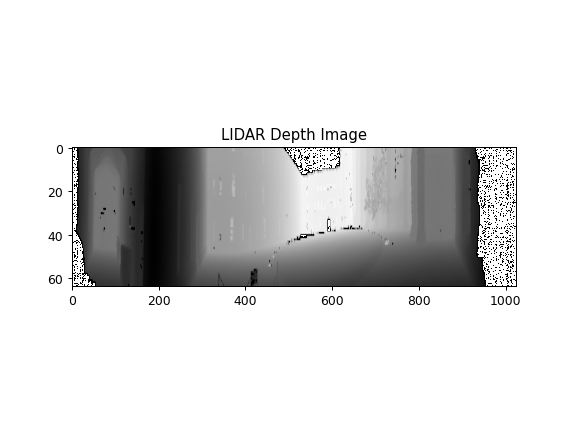

(64, 1024)


In [127]:
# test = np.tile(np.array([[18],[12],[6],[0]]), [16, 4])
test = np.zeros([64, 1024])
for i in range(np.shape(test)[0]//4):
    test[4*i,:-18] = data[4*i,18:]
    test[4*i+1,:-12] = data[4*i+1,12:]
    test[4*i+2,:-6] = data[4*i+2,6:]
    test[4*i+3,:] = data[4*i+3,:]
pcs = data[:,:,None]
fig, ax = p.subplots()
ax.set_title("LIDAR Depth Image")
ax.imshow(test, cmap = "gray", norm='log')
ax.set_aspect(5)
print(np.shape(data))

# Reproject 2D Depth image back to 3D point cloud using same convention

#### IMPORTANT: look into pixel_shift_by_row parameter from OUSTER
https://ouster.com/insights/blog/firmware-2-4-industry-standard-protocols-and-improved-alerts

In [118]:
#Get LiDAR Intrinsics
#Simulated LIDAR Sensor -- (look for <min_angle> in velodyne.world file in ROS package)
# phimin = -0.53529248 #rad
# phimax = 0.18622663 #rad

#Ouster OS1
phimin = np.deg2rad(-22.5)
phimax = np.deg2rad(22.5)

new_point_cloud_spherical = np.zeros([np.shape(pcs)[0]*np.shape(pcs)[1],3])
pc1_spherical = new_point_cloud_spherical

count = 0
for w in range(np.shape(pcs)[0]):
    for h in range(np.shape(pcs)[1]):
        new_point_cloud_spherical[count,0] = pcs[w,h,0] #radius
        new_point_cloud_spherical[count,1] = 2*np.pi*(w/np.shape(pcs)[0]) #theta
        new_point_cloud_spherical[count,2] = np.pi/2 + phimax - (phimax-phimin)*(h/np.shape(pcs)[1]) #phi
        count+= 1

new_point_cloud_cart = LC.s2c(LC,new_point_cloud_spherical).numpy()
new_point_cloud_cart[:,2] = -new_point_cloud_cart[:,2] #need to flip z 
print(np.shape(new_point_cloud_cart))
print(new_point_cloud_cart)

#shape image to have same angular field of view in width and height
vert_fov = np.rad2deg(phimax-phimin)
print(vert_fov)
vert_fov/360
print((vert_fov/360)*np.shape(pcs)[0])

(65536, 3)
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 ...
 [ 0. -0. -0.]
 [ 0. -0. -0.]
 [ 0. -0. -0.]]
45.0
8.0


In [119]:
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

color = 255*np.linspace(0,1,len(new_point_cloud_cart)) 
cname = np.array([255-color, color, 255-color]).T.tolist()
disp.append(Points(new_point_cloud_cart, c=cname,  r = 3.5, alpha =0.5))

# disp.append(Points(new_point_cloud_cart[::32], c='red',  r = 3.5, alpha =0.8))
# disp.append(Points(new_point_cloud_cart[::4], c='blue',  r = 5., alpha =0.125))

disp.append(Points(pc1, c = 'blue', r = 3.5, alpha = 0.5))

plt.show(disp, "Raw Point Cloud")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)